# System identification 7m with wPCC VCT prior

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, track_plots, plot
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vessel_manoeuvring_models.models.vmm_martin_simple import martins_simple_model as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
ships

['M5064-02-A', 'wPCC', '7m']

In [5]:
%reload_kedro
ship='7m'
prior_ship = 'wPCC'
time_series = catalog.load(f"{ship}.time_series")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
#time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)

[05/02/23 13:46:09] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=256500;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=739316;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[05/02/23 13:46:09] INFO     Kedro project phd                                                      ]8;id=876482;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=393119;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=270746;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=919074;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from '7m.time_series' (PartitionedDataSet)...         ]8;id=708224;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=202032;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=900270;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=654717;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:7m.exclude_parameters'                   ]8;id=925277;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=936874;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from '7m.time_series_meta_data' (CSVDataSet)...       ]8;id=824154;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=929018;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [6]:
ship_data_prior_ship = catalog.load(f"{prior_ship}.ship_data")

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=444531;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=333418;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [7]:
scaling = ship_data_prior_ship['scale_factor']/ship_data['scale_factor']
ship_data['I_z'] = ship_data_prior_ship['I_z']*scaling**5
ship_data['x_G'] = -9.8/ship_data_prior_ship['scale_factor']

In [8]:
ship_data

{'T': 0.284,
 'L': 7.0,
 'B': 1.3,
 'rho': 1000,
 'm': 1155,
 'scale_factor': 30,
 'TWIN': 1,
 'D': 0.17,
 'I_z': 3386.0314842592607,
 'x_G': -0.23786407766990292}

In [9]:
np.sqrt(ship_data['I_z']/ship_data['m'])/ship_data['L']

0.24460000628684303

In [10]:
72.1/206.6

0.3489835430784124

In [11]:
time_series_meta_data['tws'] = (time_series_meta_data['twsBow'] + time_series_meta_data['twsStern'])/2

<Axes: xlabel='date'>

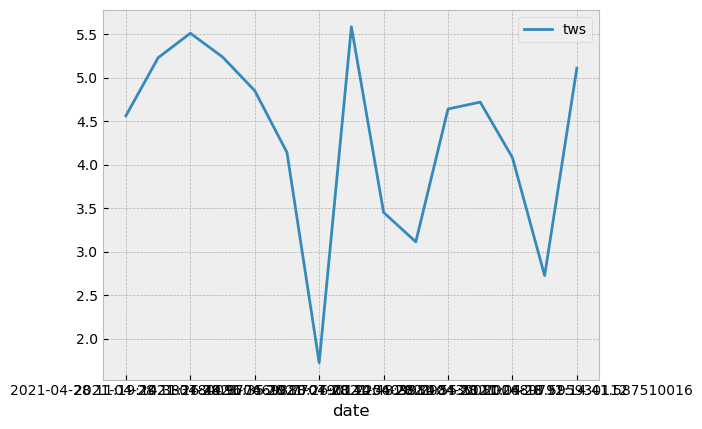

In [12]:
time_series_meta_data.plot(x='date', y='tws')

In [13]:
time_series_meta_data['delta_abs'] = time_series_meta_data['delta'].abs()
time_series_meta_data.sort_values(by='date', ascending=True)

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,delta,V,beta,u,v,psi,phi,y_GPS,x_GPS,x0,y0,date,tws,delta_abs
motorZZ_1_thruster_100_Port,4.614160,4.525495,2.486891,12.286663,12.305938,59.292991,18.324195,0.055550,0.697962,3.107473,3.132236,1.710958,0.706300,2.914798,3.133645,1.730714,0.214779,2.486891,0.302276,2.454673,0.661543,4.614160,0.055550,44.475843,315.785062,316.548351,47.173993,2021-04-28 10:26:01.225609984,1.720836,0.214779
motorZZ_2_thruster_100_Stb,3.556798,3.646648,2.388526,12.592144,12.538125,59.284942,18.323452,0.061287,0.801782,7.926677,1.237516,5.693845,0.784665,7.708125,1.201041,5.481916,0.218832,2.388526,0.356135,2.388515,0.714152,3.556798,0.061287,22.452942,321.098569,322.718239,24.741893,2021-04-28 10:40:18.614870016,5.587881,0.218832
motorZZ_3_thruster_80_Port,6.280696,6.282109,2.262368,12.716622,12.770312,59.287654,18.324165,0.099516,3.119444,2.417766,3.138106,3.484717,3.139754,2.130466,3.140242,3.418727,0.222884,2.262368,7.497672,2.250966,1.980268,6.691098,0.099516,39.969739,314.868037,317.613195,40.023059,2021-04-28 10:48:38.208430080,3.451722,0.222884
motorZZ_4_thruster_80_Stb,6.282978,6.278361,2.210224,20.308812,11.145000,59.291236,18.323485,0.058311,3.032030,2.233553,3.141137,3.112513,3.068972,2.232856,3.135590,3.112824,0.194517,2.210224,1.649388,2.207696,2.058192,6.409949,0.058311,75.484327,295.891992,296.675612,78.176643,2021-04-28 10:52:06.805670144,3.112668,0.194517
motorZZ_5_thruster_60_Stb,6.282165,6.273283,1.795074,13.440897,13.466875,59.294757,18.321576,0.040460,3.136648,3.013644,3.140824,4.461304,3.140425,3.485960,3.138969,4.821664,0.235041,1.795074,1.515657,1.790822,1.717576,6.425945,0.040460,44.931843,272.685966,274.917855,46.629282,2021-04-28 10:55:51.202689792,4.641484,0.235041
motorZZ_6_thruster_60_Port,6.281565,6.275344,1.839285,13.035028,13.002500,59.297606,18.320594,0.052482,3.136805,2.901553,3.140962,4.327306,3.135835,3.393899,3.137505,5.114666,0.226936,1.839285,1.597817,1.833096,1.720829,6.758666,0.052482,30.638473,272.248203,274.928639,30.777402,2021-04-28 10:59:02.200130048,4.720986,0.226936
motorZZ_7_thruster_40_Stb,6.282389,6.279349,1.308986,11.263334,11.145000,59.301677,18.319883,0.050605,3.138552,2.697535,3.139877,3.926706,3.138554,2.955966,3.137279,4.237384,0.194517,1.308986,2.032278,1.302223,1.229920,6.345685,0.050605,25.140704,214.983667,217.122696,26.953763,2021-04-28 11:04:18.595930112,4.082045,0.194517
motorZZ_8_thruster_40_Port,6.282058,6.280033,1.270748,11.638632,11.609375,59.303793,18.319322,0.038099,3.136076,2.205084,3.137502,2.774606,3.128708,2.022677,3.137482,2.672486,0.202622,1.270748,6.333943,1.249226,1.199217,6.398557,0.038099,15.366148,209.195752,211.984522,15.645311,2021-04-28 11:07:42.593159936,2.723546,0.202622
motorZZ_9_thruster_40,3.407302,3.616633,1.059056,11.905680,11.841563,59.302297,18.319604,0.069269,0.651276,6.338551,0.903630,5.421382,0.683296,5.699430,0.946288,4.802026,0.206674,1.059056,0.457297,1.059056,0.424083,3.407302,0.069269,5.476522,189.752303,191.995207,4.885254,2021-04-28 11:14:41.587510016,5.111704,0.206674
motorZZ_10_thruster_40,3.814295,3.925403,1.086174,10.027171,9.984063,59.300022,18.319696,0.127323,0.670234,5.673418,0.889456,4.854953,0.734507,5.074579,0.988236,4.272943,0.174255,1.086174,0.587098,1.083376,0.588585,3.814295,0.127323,8.745948,180.474807,182.941952,10.078548,2021-04-28 11:19:14.383780096,4.563948,0.174255


In [14]:
id = "motorZZ_2_thruster_100_Stb"
data_raw = time_series[str(id)]()
data_raw.drop(columns=['date'], inplace=True)

In [15]:
data_raw.head()

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,delta,V,beta,u,v,psi,phi,y_GPS,x_GPS,x0,y0
time(s),,,,,,,,,,,,,,,,,,,,,,,,,,,
0.00000,3.120886,3.106032,2.128076,2.804897,3.018437,59.284942,18.323022,0.032027,-0.618869,5.579988,-0.939304,4.133509,-0.659069,4.945075,-1.045442,3.602604,-0.052682,2.128076,0.014854,2.127841,-0.031609,3.120886,0.032027,0.000000,0.000000,-2.749159,0.552040
0.20001,3.122273,3.097148,2.122014,2.584824,2.865014,59.284938,18.323022,0.027691,-0.616928,5.582082,-0.933836,4.122666,-0.656724,4.940662,-1.040329,3.584795,-0.050004,2.122014,0.025125,2.121344,-0.053309,3.122273,0.027691,0.011402,-0.452316,-3.202238,0.559629
0.39999,3.126400,3.100304,2.146155,2.353527,2.554062,59.284934,18.323023,0.019367,-0.615155,5.587342,-0.927547,4.115124,-0.653445,4.939987,-1.032666,3.568720,-0.044577,2.146155,0.026096,2.145424,-0.055999,3.126400,0.019367,0.022960,-0.888321,-3.640482,0.559833
0.59998,3.130993,3.121191,2.132209,2.151748,2.321875,59.284930,18.323023,0.013995,-0.612801,5.592782,-0.921919,4.108716,-0.650208,4.935740,-1.026915,3.551416,-0.040524,2.132209,0.009802,2.132106,-0.020900,3.130993,0.013995,0.027334,-1.310438,-4.065036,0.551561
0.79996,3.133984,3.147556,2.155146,2.056626,2.089688,59.284926,18.323023,0.015883,-0.609977,5.597850,-0.917656,4.103262,-0.647193,4.927286,-1.023938,3.532870,-0.036472,2.155146,-0.013572,2.154947,0.029248,3.133984,0.015883,0.021092,-1.737605,-4.493758,0.537078


In [16]:
data = load(raw_data=data_raw)

delta = data['delta'] = data['delta'] - (data['delta'].max() - (data['delta'].max() - data['delta'].min())/2)
#delta = data['delta']
data['delta_deg'] = np.rad2deg(data['delta'])
data['psi_deg'] = np.rad2deg(data['psi'])
data_all = data.copy()
#data = add_thrust(data, thrust_channels=thrust_keys)

<Axes: xlabel='time(s)'>

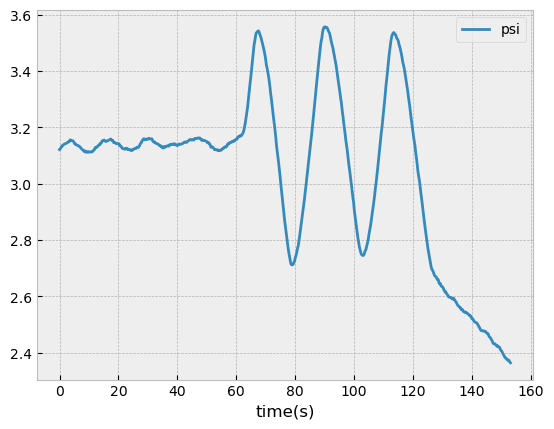

In [17]:
data_all.plot(y='psi')

<Axes: xlabel='time(s)'>

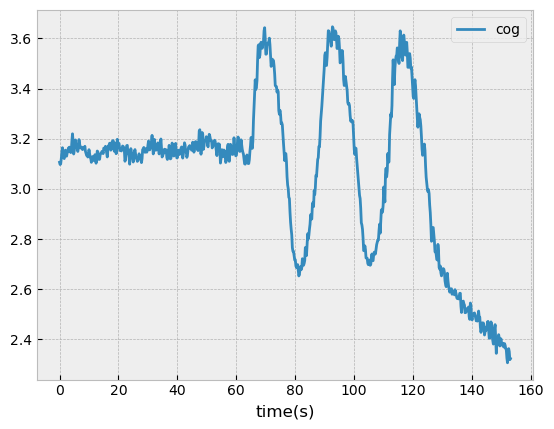

In [18]:
data.plot(y='cog')

<Axes: xlabel='time(s)'>

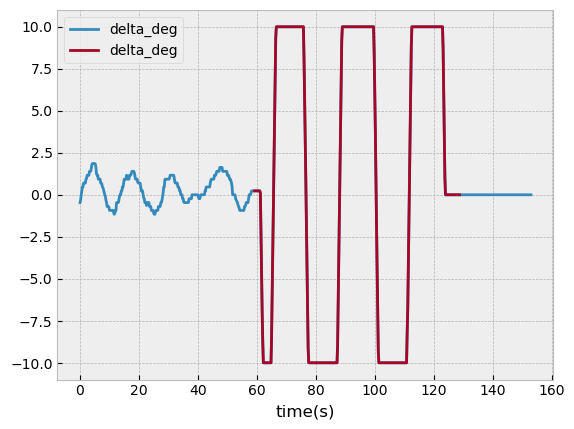

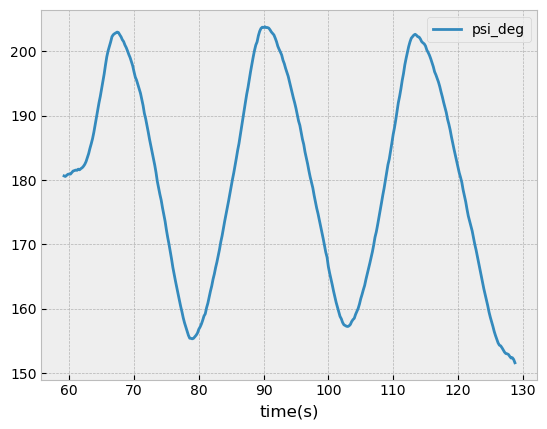

In [19]:
tolerance = 0.01
#delta = data['delta'] - (data['delta'].max() - (data['delta'].max() - data['delta'].min())/2)
    
mask = delta.abs() >= (1-tolerance)*delta.abs().max()
start = data.loc[mask].index[0]
end = data.loc[mask].index[-1]
data = data.iloc[data.index.get_loc(start)-15:data.index.get_loc(end)+30].copy()
#data = data.iloc[data.index.get_loc(start)+50:data.index.get_loc(end)+30].copy()


fig,ax=plt.subplots()
data_all.plot(y='delta_deg', ax=ax)
data.plot(y='delta_deg', ax=ax)
fig,ax=plt.subplots()
data.plot(y='psi_deg', ax=ax)

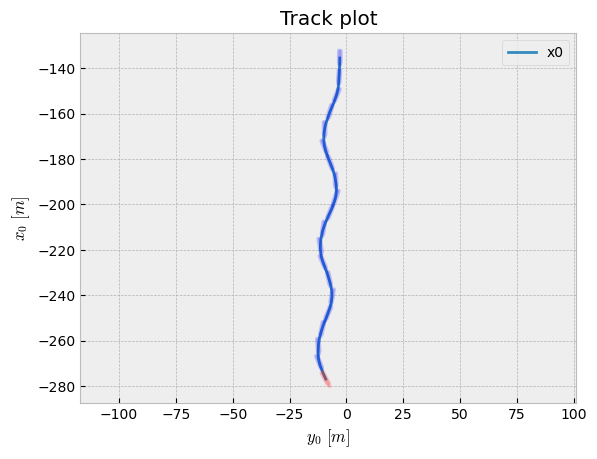

In [20]:
track_plot(df=data, lpp=ship_data['L'], beam=ship_data['B']);

In [21]:
model_VCT = Simulator.load("model_wPCC_abkowitz_simplified_VCT.pkl")
model_VCT.parameters['Xu'] = 0
model_VCT.parameters['Xvr'] = 0
model_VCT.parameters['Xdeltadelta'] = 0
#model_VCT.parameters['Ydelta']*=1.5
#model_VCT.parameters['Ndelta']*=1.5

In [22]:
model_VCT.parameters

Xudot          0.000179
Xdeltadelta    0.000000
Xu             0.000000
Xvr            0.000000
Yrdot         -0.000303
Yvdot         -0.006109
Ydelta         0.005071
Yr             0.002749
Yvvv          -0.136030
Yv            -0.009478
Yvr            0.011530
Nrdot         -0.000299
Nvdot         -0.000128
Ndelta        -0.002510
Nrrr          -0.001776
Nr            -0.002276
Nvvv           0.005319
Nv            -0.001728
dtype: float64

## Kalman filter system matrixes (-> f(...) and jacobi matrix)

In [23]:
vmm = VMM(X_eq=model_VCT.X_eq, Y_eq = model_VCT.Y_eq, N_eq = model_VCT.N_eq)

In [24]:
system_matrixes = SystemMatrixes(vmm=vmm)

In [25]:
system_matrixes._lambda_f

<function _lambdifygenerated(Nrrr, Xudot, Yrdot, I_z, Xu, Xdeltadelta, Nvvv, Yvdot, v, psi, Nvdot, Nrdot, Nv, delta, x_G, Yvr, Yvvv, r, Xvr, Yr, m, rho, Nr, Ydelta, u, L, Yv, Ndelta)>

In [26]:
system_matrixes._lambda_jacobian

<function _lambdifygenerated(Nrrr, Xudot, Yrdot, I_z, Xu, Xdeltadelta, Nvvv, Yvdot, v, psi, Nvdot, Nrdot, Nv, delta, x_G, Yvr, Yvvv, r, Xvr, Yr, m, rho, Nr, Ydelta, u, L, Yv, h, Ndelta)>

In [27]:
model_VCT.parameters

Xudot          0.000179
Xdeltadelta    0.000000
Xu             0.000000
Xvr            0.000000
Yrdot         -0.000303
Yvdot         -0.006109
Ydelta         0.005071
Yr             0.002749
Yvvv          -0.136030
Yv            -0.009478
Yvr            0.011530
Nrdot         -0.000299
Nvdot         -0.000128
Ndelta        -0.002510
Nrrr          -0.001776
Nr            -0.002276
Nvvv           0.005319
Nv            -0.001728
dtype: float64

## model VCT initial guessed parameters

In [28]:
#parameters = {key:value for key,value in model_VCT.parameters.items() if not 'dot' in key}
parameters = model_VCT.parameters.to_dict()

In [29]:
parameters

{'Xudot': 0.00017880704448812042,
 'Xdeltadelta': 0.0,
 'Xu': 0.0,
 'Xvr': 0.0,
 'Yrdot': -0.00030313777458141895,
 'Yvdot': -0.006109387408263365,
 'Ydelta': 0.005070904026172084,
 'Yr': 0.0027490862690183375,
 'Yvvv': -0.1360301584182113,
 'Yv': -0.009478116807560617,
 'Yvr': 0.011529803823462904,
 'Nrdot': -0.00029867482773178765,
 'Nvdot': -0.00012825440172375716,
 'Ndelta': -0.002509856249422254,
 'Nrrr': -0.001775839336334204,
 'Nr': -0.002276428666283562,
 'Nvvv': 0.0053190979450702496,
 'Nv': -0.0017282236038403535}

In [30]:
parameters['Nrdot']

-0.00029867482773178765

## Extended Kalman Filter

In [31]:
ek = ExtendedKalman(
        vmm=vmm,
        parameters=parameters,
        ship_parameters=ship_data,
        system_matrixes=system_matrixes,
    )

In [32]:
ek.parameters

Xu             0.000000
Yvvv          -0.136030
Nvvv           0.005319
Nr            -0.002276
Ydelta         0.005071
Nrdot         -0.000299
Yv            -0.009478
Yvr            0.011530
Ndelta        -0.002510
Nv            -0.001728
Yrdot         -0.000303
Yr             0.002749
Nvdot         -0.000128
Xvr            0.000000
Yvdot         -0.006109
Xudot          0.000179
Xdeltadelta    0.000000
Nrrr          -0.001776
dtype: float64

In [33]:
ek.get_all_coefficients(sympy_symbols=False)

['Xu',
 'Yvvv',
 'Nvvv',
 'Nr',
 'Ydelta',
 'Nrdot',
 'Yv',
 'Yvr',
 'Ndelta',
 'Nv',
 'Yrdot',
 'Yr',
 'Nvdot',
 'Xvr',
 'Yvdot',
 'Xudot',
 'Xdeltadelta',
 'Nrrr']

In [34]:
x0 = initial_state(data)

In [35]:
ek_covariance_input = yaml.safe_load("""
process_variance:
  u : 0.003
  v : 0.003
  r : 0.019  # [deg]
measurement_error_max:
  positions: 0.05
  psi: 0.5  # [deg]
"""
)     

 
                                     
covariance_matrixes = guess_covariance_matrixes(ek_covariance_input=ek_covariance_input,data=data)

In [36]:
covariance_matrixes

{'P_prd': [[0.0002777777777777778, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0002777777777777778, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 8.461594994075238e-06, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0006052096512000002, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0006052096512000002, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 6.68983734958142e-05]],
 'Qd': [[0.0006052096512000002, 0.0, 0.0],
  [0.0, 0.0006052096512000002, 0.0],
  [0.0, 0.0, 6.68983734958142e-05]],
 'Rd': [[0.0002777777777777778, 0.0, 0.0],
  [0.0, 0.0002777777777777778, 0.0],
  [0.0, 0.0, 8.461594994075238e-06]]}

## Filter states with initially guessed model

In [37]:
ek2, data_ek, time_steps = extended_kalman_filter(ek=ek, data=data, covariance_matrixes=covariance_matrixes, x0=x0, hydrodynamic_derivatives=parameters)
ek_smooth, data_ek_smooth = extended_kalman_smoother(ek=ek2, data=data, time_steps=time_steps, covariance_matrixes=covariance_matrixes, hydrodynamic_derivatives=parameters)

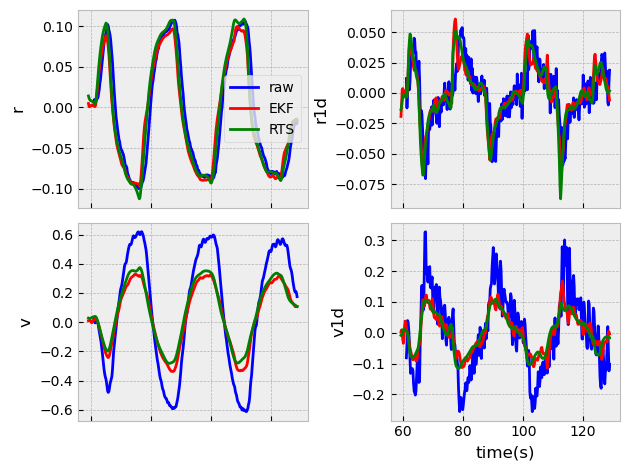

In [135]:
data_ = data.copy()

dataframes = {
'raw':data_.rolling(window=10).mean(),
'EKF':data_ek,
'RTS':data_ek_smooth,
}
plot(dataframes=dataframes, keys=['v','r','v1d','r1d']);


## Inverse dynamics regression

In [39]:
added_masses = extract_added_masses(parameters=parameters)

In [81]:
data_with_force = predict_force(data=data.rolling(window=2).mean().dropna(), added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)

#data_with_force = predict_force(data=data_ek_smooth, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)
#data_with_force = predict_force(data=data_ek, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)

<Axes: xlabel='delta'>

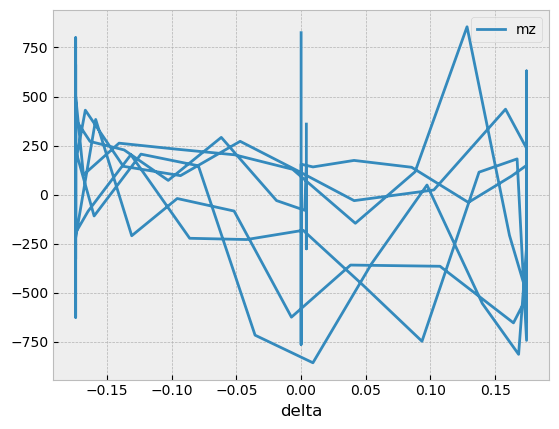

In [82]:
data_with_force.plot(x='delta', y='mz')

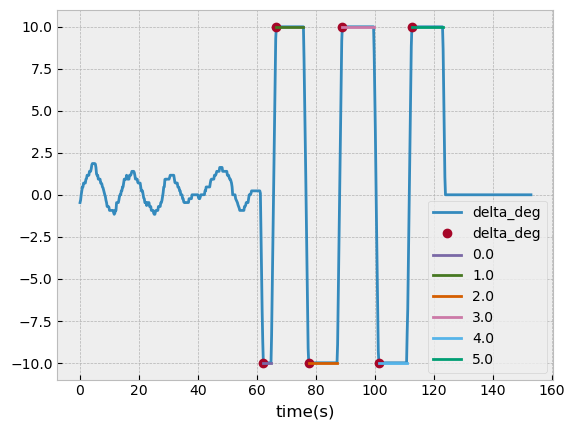

In [83]:
tolerance = 0.001
#delta = data['delta'] - (data['delta'].max() - (data['delta'].max() - data['delta'].min())/2)
    
mask = data_all['delta'].abs() >= (1-tolerance)*data_all['delta'].abs().max()
data_ = data_all.loc[mask]

dt = np.mean(np.diff(data.index))

mask = np.concatenate(([True],data_.index[1:] - data_.index[0:-1] > 2*dt))
starts = data_.loc[mask]
data_.loc[mask,'group'] = np.arange(0,len(starts))
data_['group'].fillna(method='ffill', inplace=True)
          
fig,ax=plt.subplots()
data_all.plot(y='delta_deg', ax=ax)
starts.plot(y='delta_deg', style='o', ax=ax)

for group,df_ in data_.groupby(by='group'):
    df_.plot(y='delta_deg', style='-', label=group, ax=ax)


In [84]:
start = data_.groupby(by='group').get_group(1).index[0]
end = data_.groupby(by='group').get_group(4).index[-1]
df_ = data_with_force.loc[start:end]

<Axes: xlabel='time(s)'>

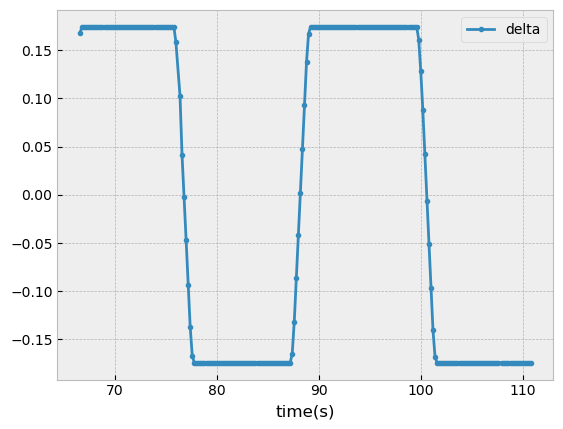

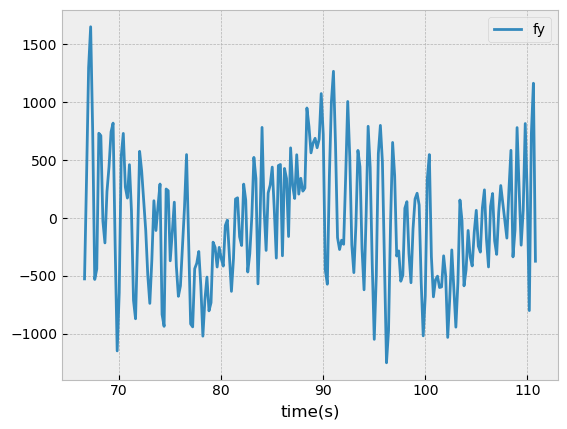

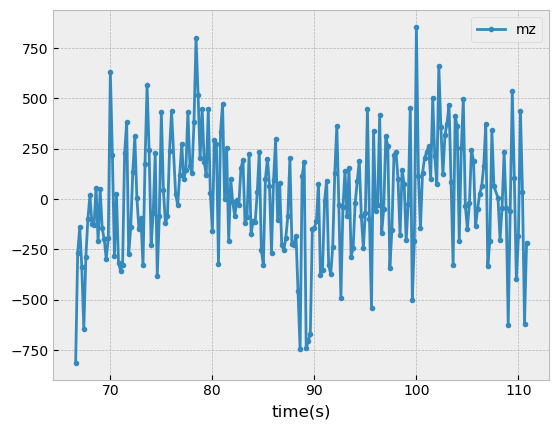

In [85]:
df_.plot(y='delta', style='.-')
df_.plot(y='fy', style='-')
df_.plot(y='mz', style='.-')

In [86]:
df_['mz'].mean()

9.205502199266274

In [87]:
regression, derivatives = fit_motions(data=data_with_force, added_masses=added_masses, ship_data=ship_data, vmm=vmm)

In [88]:
derivatives

,regressed,$P_{value}$,$conf_{lower}$,$conf_{higher}$
Ndelta,-0.002371,4.211183e-31,-0.002734,-0.002009
Nr,-0.002679,9.505669e-07,-0.003735,-0.001624
Nrrr,-0.003590,2.218573e-01,-0.009360,0.002180
Nv,-0.001716,5.185685e-03,-0.002916,-0.000516
Nvvv,-0.002178,6.807464e-01,-0.012580,0.008224
Xdeltadelta,0.000011,9.980222e-01,-0.008377,0.008398
Xu,0.000186,1.532176e-01,-0.000070,0.000441
Xvr,-0.002601,5.881771e-02,-0.005299,0.000097
Ydelta,0.017108,1.092416e-09,0.011741,0.022474
Yr,-0.007123,2.669581e-01,-0.019722,0.005477


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fx   R-squared (uncentered):                   0.114
Model:                            OLS   Adj. R-squared (uncentered):              0.106
Method:                 Least Squares   F-statistic:                              14.60
Date:                Tue, 02 May 2023   Prob (F-statistic):                    5.74e-09
Time:                        13:50:40   Log-Likelihood:                          1938.8
No. Observations:                 345   AIC:                                     -3872.
Df Residuals:                     342   BIC:                                     -3860.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Xu              0.0002      0.000      1.431      0.153   -6.96e-05       0.000
Xdeltadelta  1.058e-05      0.004      0.002      0.998      -0.008       0.008
Xvr            -0.0026      0.001     -1.896      0.059      -0.005    9.75e-05
==============================================================================
Omnibus:                        1.303   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.521   Jarque-Bera (JB):                1.402
Skew:                           0.133   Prob(JB):                        0.496
Kurtosis:                       2.835   Cond. No.                         88.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fy   R-squared (uncentered):                   0.326
Model:                            OLS   Adj. R-squared (uncentered):              0.316
Method:                 Least Squares   F-statistic:                              32.88
Date:                Tue, 02 May 2023   Prob (F-statistic):                    2.44e-27
Time:                        13:50:40   Log-Likelihood:                          1383.3
No. Observations:                 345   AIC:                                     -2757.
Df Residuals:                     340   BIC:                                     -2737.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ydelta         0.0171      0.003      6.270      0.000       0.012       0.022
Yr            -0.0071      0.006     -1.112      0.267      -0.020       0.005
Yv            -0.0221      0.008     -2.689      0.008      -0.038      -0.006
Yvvv          -0.0558      0.056     -0.998      0.319      -0.166       0.054
Yvr           -0.0040      0.005     -0.829      0.408      -0.013       0.005
==============================================================================
Omnibus:                        0.510   Durbin-Watson:                   1.290
Prob(Omnibus):                  0.775   Jarque-Bera (JB):                0.301
Skew:                           0.019   Prob(JB):                        0.860
Kurtosis:                       3.139   Cond. No.                         77.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     mz   R-squared (uncentered):                   0.388
Model:                            OLS   Adj. R-squared (uncentered):              0.379
Method:                 Least Squares   F-statistic:                              43.18
Date:                Tue, 02 May 2023   Prob (F-statistic):                    2.09e-34
Time:                        13:50:40   Log-Likelihood:                          2304.5
No. Observations:                 345   AIC:                                     -4599.
Df Residuals:                     340   BIC:                                     -4580.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ndelta        -0.0024      0.000    -12.857      0.000      -0.003      -0.002
Nr            -0.0027      0.001     -4.993      0.000      -0.004      -0.002
Nv            -0.0017      0.001     -2.813      0.005      -0.003      -0.001
Nrrr          -0.0036      0.003     -1.224      0.222      -0.009       0.002
Nvvv          -0.0022      0.005     -0.412      0.681      -0.013       0.008
==============================================================================
Omnibus:                        0.481   Durbin-Watson:                   1.689
Prob(Omnibus):                  0.786   Jarque-Bera (JB):                0.361
Skew:                           0.075   Prob(JB):                        0.835
Kurtosis:                       3.050   Cond. No.                         115.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

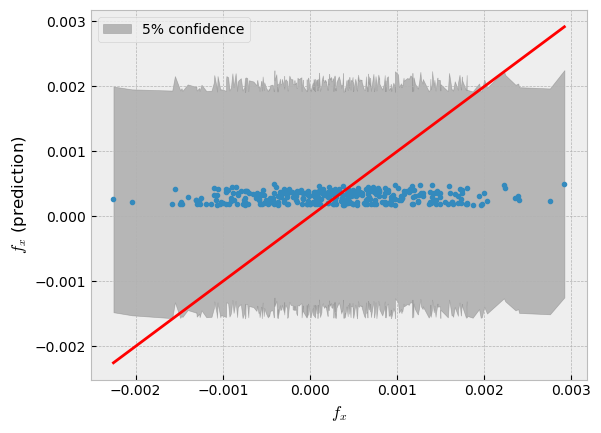

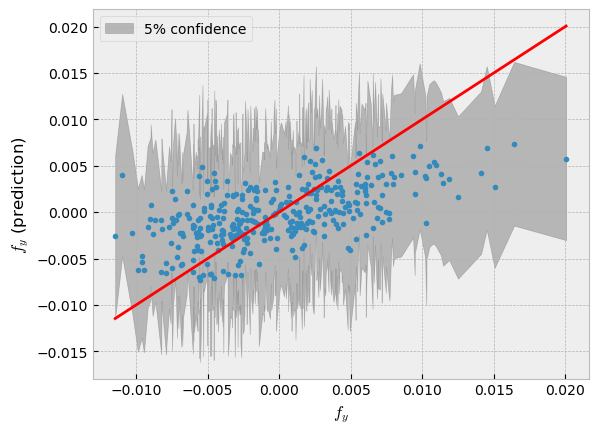

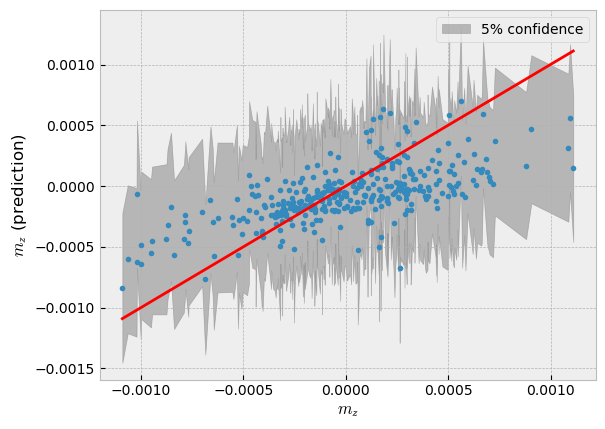

In [89]:
regression.show()

In [90]:
model = create_model_from_motion_regression(regression=regression)

In [91]:
#model.simulate(data_ek_smooth)

In [125]:
data_ = data_ek_smooth.copy()
data_['psi']+=np.deg2rad(1)
data_['delta']-=np.deg2rad(0.8)
data_simulated = simulate_euler(data=data_, model=model, ek=ek)

In [126]:
model_guess = model.copy()
model_guess.parameters = {key:parameters.get(key,0) for key in model.parameters.keys()}
data_simulated_guess = simulate_euler(data=data_ek_smooth, model=model_guess, ek=ek)

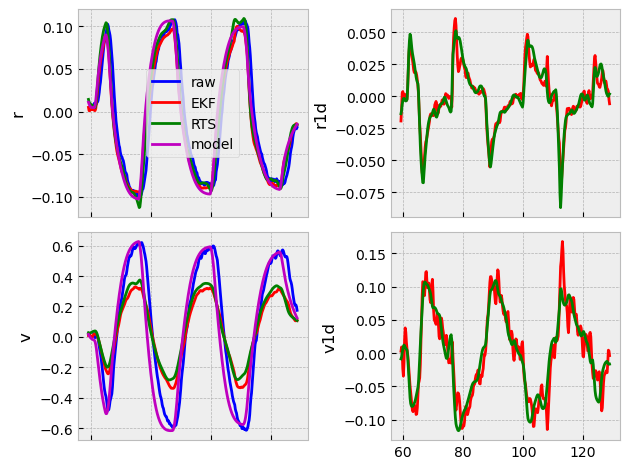

In [127]:
data_ = data.drop(columns=['v1d','r1d'])

dataframes = {
'raw':data_.rolling(window=10).mean(),
'EKF':data_ek,
'RTS':data_ek_smooth,
'model':data_simulated,
}
plot(dataframes=dataframes, keys=['v','r','v1d','r1d']);

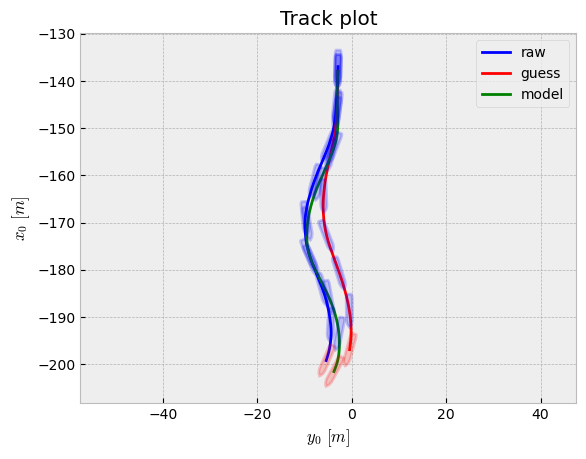

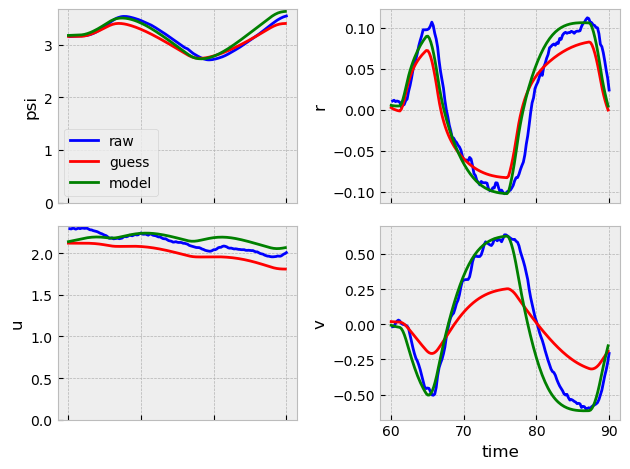

In [131]:

dataframes = {
'raw':data.rolling(5).mean(),
'guess':data_simulated_guess,
'model':data_simulated,
}
time_window=[60,90]
track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], time_window=time_window);
plot(dataframes, keys=['u','v','r','psi'], time_window=time_window);

In [96]:
covariance_matrixes

{'P_prd': [[0.0002777777777777778, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0002777777777777778, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 8.461594994075238e-06, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0006052096512000002, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0006052096512000002, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 6.68983734958142e-05]],
 'Qd': [[0.0006052096512000002, 0.0, 0.0],
  [0.0, 0.0006052096512000002, 0.0],
  [0.0, 0.0, 6.68983734958142e-05]],
 'Rd': [[0.0002777777777777778, 0.0, 0.0],
  [0.0, 0.0002777777777777778, 0.0],
  [0.0, 0.0, 8.461594994075238e-06]]}